## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time

import scipy.io as sio

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers

keras = tf.keras

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(False)


def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
# Loading Data
import pandas as pd
#!ls /content/drive/'My Drive'/'Colab Notebooks'
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Term_project_simulation/selected_data_ISONE.csv')
data.head()

date  year  month  day  weekday  hour   demand  temperature
0  2003/3/1  2003      3    1        7     1  12863.0           23
1  2003/3/1  2003      3    1        7     2  12389.0           22
2  2003/3/1  2003      3    1        7     3  12155.0           21
3  2003/3/1  2003      3    1        7     4  12072.0           21
4  2003/3/1  2003      3    1        7     5  12160.0           22

In [7]:
data['load'] = data['demand']/data['demand'].values.max()
data.head()

date  year  month  day  weekday  hour   demand  temperature      load
0  2003/3/1  2003      3    1        7     1  12863.0           23  0.465680
1  2003/3/1  2003      3    1        7     2  12389.0           22  0.448519
2  2003/3/1  2003      3    1        7     3  12155.0           21  0.440048
3  2003/3/1  2003      3    1        7     4  12072.0           21  0.437043
4  2003/3/1  2003      3    1        7     5  12160.0           22  0.440229

In [8]:
data = data.set_index("date")
data.head()

year  month  day  weekday  hour   demand  temperature      load
date                                                                     
2003/3/1  2003      3    1        7     1  12863.0           23  0.465680
2003/3/1  2003      3    1        7     2  12389.0           22  0.448519
2003/3/1  2003      3    1        7     3  12155.0           21  0.440048
2003/3/1  2003      3    1        7     4  12072.0           21  0.437043
2003/3/1  2003      3    1        7     5  12160.0           22  0.440229

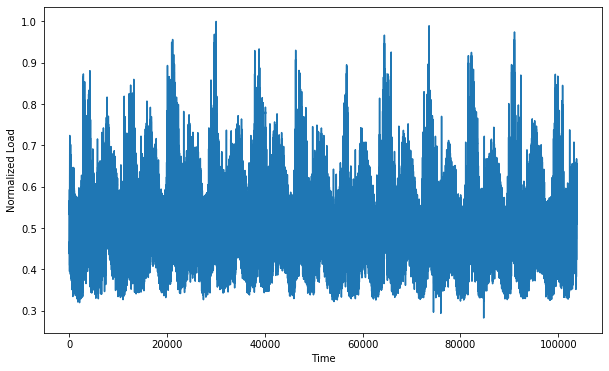

In [9]:
actual_data = data['load'].values
actual_data.shape
t = np.arange(len(actual_data))
sio.savemat('load.mat', {'load':actual_data})
plt.figure(figsize=(10,6))
# summarize history for accuracy
plt.plot(t,actual_data)
#plt.title('model accuracy')
plt.ylabel('Normalized Load')
plt.xlabel('Time')
plt.show()

In [10]:
series = data.loc[:'2006/12/31']
series.head()

year  month  day  weekday  hour   demand  temperature      load
date                                                                     
2003/3/1  2003      3    1        7     1  12863.0           23  0.465680
2003/3/1  2003      3    1        7     2  12389.0           22  0.448519
2003/3/1  2003      3    1        7     3  12155.0           21  0.440048
2003/3/1  2003      3    1        7     4  12072.0           21  0.437043
2003/3/1  2003      3    1        7     5  12160.0           22  0.440229

In [11]:
series.tail()

year  month  day  weekday  hour   demand  temperature      load
date                                                                       
2006/12/31  2006     12   31        1    20  16400.0           30  0.593730
2006/12/31  2006     12   31        1    21  15742.0           31  0.569908
2006/12/31  2006     12   31        1    22  15020.0           30  0.543769
2006/12/31  2006     12   31        1    23  14233.0           29  0.515278
2006/12/31  2006     12   31        1    24  13442.0           29  0.486641

In [12]:
train_series = series.loc[:'2005/12/31']
train_series.tail()

year  month  day  weekday  hour   demand  temperature      load
date                                                                       
2005/12/31  2005     12   31        7    20  17052.0           26  0.617334
2005/12/31  2005     12   31        7    21  16334.0           29  0.591340
2005/12/31  2005     12   31        7    22  15564.0           29  0.563464
2005/12/31  2005     12   31        7    23  14804.0           29  0.535950
2005/12/31  2005     12   31        7    24  14000.0           29  0.506842

In [13]:
valid_series = series.loc['2006/1/1':]
valid_series.tail(2)

year  month  day  weekday  hour   demand  temperature      load
date                                                                       
2006/12/31  2006     12   31        1    23  14233.0           29  0.515278
2006/12/31  2006     12   31        1    24  13442.0           29  0.486641

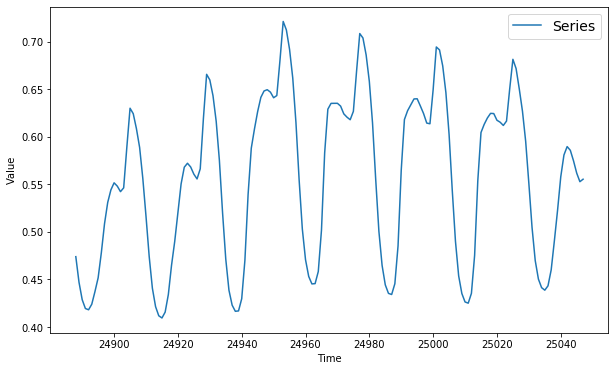

In [14]:
# Entire Series
split_time = len(train_series)
Series = series['load'].values
time = np.arange(len(series))

x_train = Series[:split_time]
x_valid = Series[split_time:]

time_valid = time[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid,start =0, end=160, label="Series")

In [0]:
# Wavenet 32
export_path_sm = "/{}.h5".format("content/drive/My Drive/Colab Notebooks/Term_project_simulation/wavenet_32_new_2")
wavenet_32 = tf.keras.models.load_model(
  export_path_sm,
  custom_objects={'KerasLayer': hub.KerasLayer})

model = wavenet_32 
wavenet_32.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 1)           3

In [0]:
window_size = 24
cnn_forecast = model_forecast(model, Series[..., np.newaxis], window_size)
cnn_forecast_32 = cnn_forecast[split_time - window_size:-1, -1, 0]

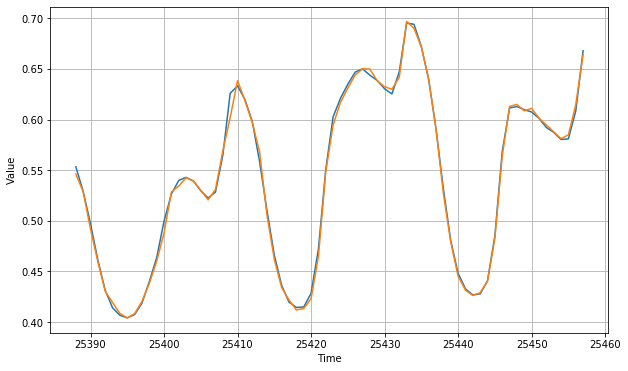

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=500, end = 570)
plot_series(time_valid, cnn_forecast_32,start=500, end = 570)

In [0]:
mape = keras.metrics.mean_absolute_percentage_error(x_valid, cnn_forecast).numpy()
mae = keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

5.0299575e-05

In [0]:
# Wavenet 64
export_path_sm = "/{}.h5".format("content/drive/My Drive/Colab Notebooks/Term_project_simulation/wavenet_64_new")
wavenet_64 = tf.keras.models.load_model(
  export_path_sm,
  custom_objects={'KerasLayer': hub.KerasLayer})

model = wavenet_64 
wavenet_64.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          2

In [0]:
cnn_forecast = model_forecast(model, Series[..., np.newaxis], window_size)
cnn_forecast_64 = cnn_forecast[split_time - window_size:-1, -1, 0]

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=500, end = 570)
plot_series(time_valid, cnn_forecast_64,start=500, end = 570)

In [0]:
mape = keras.metrics.mean_absolute_percentage_error(x_valid, cnn_forecast_64).numpy()
mae = keras.metrics.mean_absolute_error(x_valid, cnn_forecast_64).numpy()


0.004136879

In [0]:
# Wavenet 128
export_path_sm = "/{}.h5".format("content/drive/My Drive/Colab Notebooks/Term_project_simulation/wavenet_128_new")
wavenet_128 = tf.keras.models.load_model(
  export_path_sm,
  custom_objects={'KerasLayer': hub.KerasLayer})

model = wavenet_128 
wavenet_128.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          2

In [0]:
cnn_forecast = model_forecast(model, Series[..., np.newaxis], window_size)
cnn_forecast_128 = cnn_forecast[split_time - window_size:-1, -1, 0]

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=500, end = 550)
plot_series(time_valid, cnn_forecast_128,start=500, end = 550)

In [0]:
mape = keras.metrics.mean_absolute_percentage_error(x_valid, cnn_forecast_128).numpy()
mae = keras.metrics.mean_absolute_error(x_valid, cnn_forecast_128).numpy()
mae

0.0036349685

In [0]:
sio.savemat('np_vector.mat', {'cnn_128':cnn_forecast_128,'x_valid':x_valid, 'time_valid':time_valid})


In [0]:
# Wavenet 128
export_path_sm = "/{}.h5".format("content/drive/My Drive/Colab Notebooks/Term_project_simulation/wavenet_256_new")
wavenet_256 = tf.keras.models.load_model(
  export_path_sm,
  custom_objects={'KerasLayer': hub.KerasLayer})

model = wavenet_256 
wavenet_256.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          2

In [0]:
cnn_forecast = model_forecast(model, Series[..., np.newaxis], window_size)
cnn_forecast_256 = cnn_forecast[split_time - window_size:-1, -1, 0]

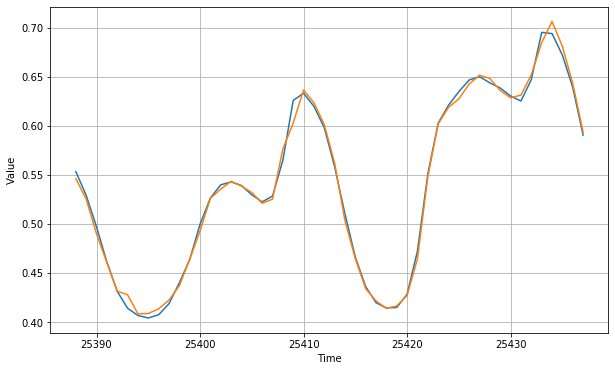

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=500, end = 550)
plot_series(time_valid, cnn_forecast_128,start=500, end = 550)

In [0]:
mape = keras.metrics.mean_absolute_percentage_error(x_valid, cnn_forecast_256).numpy()
mae = keras.metrics.mean_absolute_error(x_valid, cnn_forecast_256).numpy()
mape

0.8414944

# Generalization from 2004-2009


In [0]:
series_2 = data.loc['2004/1/1':'2011/12/31']

In [0]:
train_series = series_2.loc[:'2009/12/31']
split_time = len(train_series)

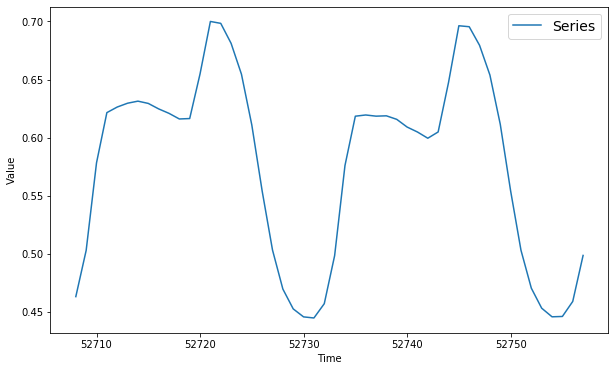

In [17]:
Series_2 = series_2['load'].values
time = np.arange(len(series_2))

x_train = Series_2[:split_time]
x_valid = Series_2[split_time:]

time_valid = time[split_time:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid,start =100, end=150, label="Series")

In [0]:
import time
start = time.time()
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 24
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32, 64, 128):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )


model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

end = time.time()

print("Time elasped in minutes", (end-start)/60)

Epoch 1/100
411/411 [==============================] - 37s 90ms/step - loss: 0.0471 - mape: 42.1024
Epoch 2/100
411/411 [==============================] - 36s 87ms/step - loss: 0.0022 - mape: 10.4540
Epoch 3/100
411/411 [==============================] - 36s 88ms/step - loss: 9.2905e-04 - mape: 6.5110
Epoch 4/100
411/411 [==============================] - 36s 88ms/step - loss: 3.4868e-04 - mape: 3.7846
Epoch 5/100
411/411 [==============================] - 36s 88ms/step - loss: 2.1097e-04 - mape: 2.7653
Epoch 6/100
411/411 [==============================] - 36s 87ms/step - loss: 1.7442e-04 - mape: 2.4379
Epoch 7/100
411/411 [==============================] - 36s 87ms/step - loss: 1.5852e-04 - mape: 2.2749
Epoch 8/100
411/411 [==============================] - 36s 88ms/step - loss: 1.4191e-04 - mape: 2.0794
Epoch 9/100
411/411 [==============================] - 36s 88ms/step - loss: 1.2777e-04 - mape: 1.9149
Epoch 10/100
411/411 [==============================] - 36s 88ms/step - loss: 1

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 0.1])

[0.0001, 0.1, 0, 0.1]

In [0]:
import time
start = time.time()
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 24
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32, 64, 128):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )


model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=1e-2)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mape"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])
end = time.time()
print("Time elasped in minutes", (end-start)/60)

Epoch 1/500
411/411 [==============================] - 44s 106ms/step - loss: 0.0034 - mape: 8.4093 - val_loss: 0.0000e+00 - val_mape: 0.0000e+00
Epoch 2/500
411/411 [==============================] - 39s 96ms/step - loss: 2.2547e-04 - mape: 2.6546 - val_loss: 1.5042e-04 - val_mape: 2.2380
Epoch 3/500
411/411 [==============================] - 39s 95ms/step - loss: 2.4052e-04 - mape: 2.4762 - val_loss: 1.1083e-04 - val_mape: 1.8552
Epoch 4/500
411/411 [==============================] - 39s 95ms/step - loss: 2.2668e-04 - mape: 2.3622 - val_loss: 1.1078e-04 - val_mape: 1.9116
Epoch 5/500
411/411 [==============================] - 39s 96ms/step - loss: 3.2340e-04 - mape: 2.4823 - val_loss: 1.0413e-04 - val_mape: 1.7807
Epoch 6/500
411/411 [==============================] - 39s 95ms/step - loss: 1.1009e-04 - mape: 1.7925 - val_loss: 1.0397e-04 - val_mape: 1.8628
Epoch 7/500
411/411 [==============================] - 39s 95ms/step - loss: 1.4110e-04 - mape: 2.0914 - val_loss: 9.3812e-05 - v

In [0]:
model = keras.models.load_model("my_checkpoint.h5")

export_path_keras = "/{}.h5".format("content/drive/My Drive/Colab Notebooks/Term_project_simulation/wavenet_128_2")
print(export_path_keras)
model.save(export_path_keras)

/content/drive/My Drive/Colab Notebooks/Term_project_simulation/wavenet_128_2.h5


In [0]:
cnn_forecast = model_forecast(model, Series_2[..., np.newaxis], window_size)
cnn_forecast_128 = cnn_forecast[split_time - window_size:-1, -1, 0]

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=500, end = 700)
plot_series(time_valid, cnn_forecast_128,start=500, end = 700)

In [0]:
mape = keras.metrics.mean_absolute_percentage_error(x_valid, cnn_forecast_128).numpy()
mae = keras.metrics.mean_absolute_error(x_valid, cnn_forecast_128).numpy()
mape

1.0605134

In [0]:
valid_series = series_2.loc['2010/1/1':'2011/12/31']
len(valid_series)

17520

In [0]:
year1 = series_2.loc['2010/1/1':'2010/12/31']
x1 = len(year1)
x1

8760

In [0]:
mape = keras.metrics.mean_absolute_percentage_error(x_valid[:x1], cnn_forecast_128[:x1]).numpy()
mape

1.0461907

In [0]:
mape = keras.metrics.mean_absolute_percentage_error(x_valid[x1:], cnn_forecast_128[x1:]).numpy()
mape

1.0748363

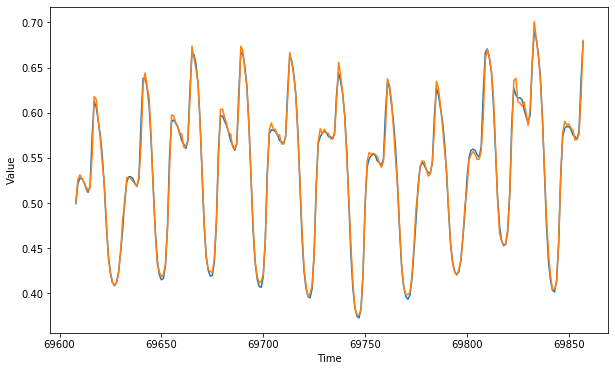

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=17000, end = 17250)
plot_series(time_valid, cnn_forecast_128,start=17000, end = 17250)

In [0]:
sio.savemat('history.mat', {'loss':history.history['loss'],'val_loss':history.history['val_loss']})

In [0]:
sio.savemat('history2.mat', {'loss':history.history['mape'],'val_loss':history.history['val_mape']})

In [18]:
# Wavenet 128
export_path_sm = "/{}.h5".format("content/drive/My Drive/Colab Notebooks/Term_project_simulation/wavenet_128_2")
wavenet_256 = tf.keras.models.load_model(
  export_path_sm,
  custom_objects={'KerasLayer': hub.KerasLayer})

model = wavenet_256 
wavenet_256.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          2080      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          2

In [0]:
window_size = 24
cnn_forecast = model_forecast(model, Series_2[..., np.newaxis], window_size)
cnn_forecast_128 = cnn_forecast[split_time - window_size:-1, -1, 0]

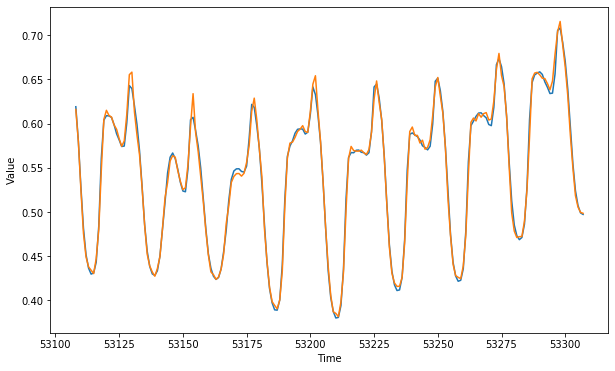

In [21]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=500, end = 700)
plot_series(time_valid, cnn_forecast_128,start=500, end = 700)

In [0]:
sio.savemat('plot3.mat', {'truth':x_valid,'forecast':cnn_forecast_128})